# Assignment 3

### Brandon Pardi

This assignment on neural networks has two parts. The first part has multiple questions. Put your answers in the solution blocks. The second part is a programming assignment. The total points for this assignment is 15.

**Due: Nov. 21, 11:59PM**


To submit your assignment, print the notebook with all outputs included and upload the PDF to Catcourse.

## Part I Questions on neural networks (7 points)

1. (1 point) Consider a univariate regression $\bar{y}=wx$ where $w\in R$, and $x\in R^{1\times m}$. The cost function is the squared error cost $L=\frac{1}{m}||\bar{y}-y||^2$. Which of the following
 equation is true?

 a. $\frac{\partial{L}}{\partial{w}}=\frac{1}{m}(\bar{y}-y)x^T$

 b. $\frac{\partial{L}}{\partial{w}}=\frac{1}{m}(\bar{y}-y)x$

 c. $\frac{\partial{L}}{\partial{w}}=\frac{2}{m}(\bar{y}-y)x^T$

 d. $\frac{\partial{L}}{\partial{w}}=\frac{2}{m}(\bar{y}-y)x$

Solution: c

2. (1 points) Which of the following propositions are true about a CONV layer? (Check
 all that apply.)

 (a)The number of weights depends on the depth of the input volume.

 (b)The number of biases is equal to the number of filters.

 (c)The total number of parameters depends on the stride.

 (d)The total number of parameters depends on the padding.


Solution: a, b, c, d

note the formula for output dimensions of a conv layer:
output_dim = ((input_dim + 2*padding - kernel_size) / stride) + 1 
(where 1 is the bias component)

3. (1 point) You are given the following piece of code for forward propagation through a
 single hidden layer in a neural network. This layer uses the sigmoid activation. Identify and correct the error.

In [125]:
import numpy as np

def forward_prop(W, a_prev, b):
  z=W*a_prev+b
  a=1/(1+np.exp(-z)) #sigmoid returna

Solution: W and a_prev are vectors and need to be dotted

In [126]:
import numpy as np

def forward_prop(W, a_prev, b):
  z=np.dot(W,a_prev)+b
  a=1/(1+np.exp(-z)) #sigmoid returna
  return a

4. (3 points) You come up with a CNN classifier. For each layer, calculate the number of weights, number of biases and the size of the associated feature maps. The notation follows the convention:

- CONV-K-N denotes a convolutional layer with N filters, each them of size KxK, Padding and stride parameters are always 0 and 1 respectively (No padding is added).

- POOL-K indicates a K x K pooling layer with stride K and padding 0.

- FC-N stands for a fully-connected layer with N neurons.

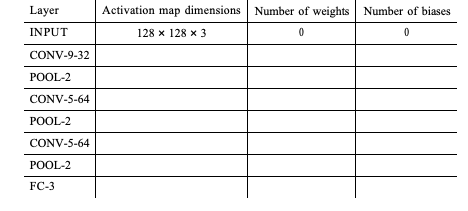

Solution (put activation map dimensions, number of weights and number of biases respectively):
filters after conv: N_filters * w_filter * h_filter * channels
CONV-9-32: 120x120x32, 2592, 32

POOL-2: 60x60x32, 0, 0

CONV-5-64: 56x56x64, 1600, 64

POOL-2: 28x28x64, 0, 0

CONV-5-64: 24x24x64, 1600, 64

POOL-2: 12x12x64, 0, 0

FC-3: 3x1, 27648, 3

5. (1 points) Why is it important to place non-linearities between the layers of neural networks?

Solution:

without nonlinearities, no matter how many layers you stack it would still behave like a single layer linear network, and the the model would not be able to learn the complex relations between features. This is because real world data is typically highly nonlinear, and a linear model would be unable to capture the relations. 

## Part II Image Classification using Convolutional neural network (8 points)

You are supposed to complete the missing code and plot the classification results as requested.

In [127]:
%matplotlib inline


Training an image classifier
=====================
Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this assignment, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

You are asked do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [2]:
'''SSL certificate error
when using provided code to load cifar10, received ssl certificate error
the following code is to disable ssl verification to fix this
'''

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



torch.Size([3, 32, 32])
 bird  ship   car  deer


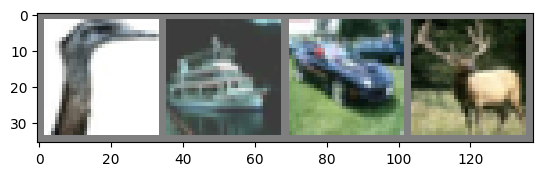

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images[0].shape)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network that takes 3-channel images



In [15]:
import torch.nn as nn
import torch.nn.functional as F

# complete the code bellow
# You are asked to implement a CNN that contains the following layers sequentially:
# 1. 2D convolution layer with kernel size 5, input depth 3, output depth 6, no padding, stride 1
# 2. Relu layer
# 3. 2x2 Pooling layer with stride 2
# 4. 2D convolution layer with kernel size 5, input depth 6, output depth 16, no padding, stride 1
# 5. Relu layer
# 6. 2x2 Pooling layer with stride 2
# 7. flattening layer
# 8. fully connected layer, output dimension is 128
# 9. Relu layer
# 10. Fully connected layer, output dimension is 64
# 11. Relu layer
# 12. Fully connected layer, output dimension is 10

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # complete code here
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.lin1 = nn.Linear(16*5*5, 128)
        self.lin2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)

    def forward(self, x):
        # complete code here
        # indim = 32
        x = self.conv1(x) # outdim 28
        x = F.relu(x)
        x = self.pool(x) # outdim 14
        x = self.conv2(x) # outdim 10
        x = F.relu(x)
        x = self.pool(x) # outdim 5
        x = x.flatten(start_dim=1)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.output(x) # no final relu since using CE with logits loss

        return x

net = Net().to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 128]          51,328
            Linear-6                   [-1, 64]           8,256
            Linear-7                   [-1, 10]             650
Total params: 63,106
Trainable params: 63,106
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


3. Define a Loss function and optimizer


Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [132]:
import torch.optim as optim

# complete the code bellow
# use cross entropy loss
# use SGD with momentum (learning rate 0.002, momentum 0.9)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=2e-3, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [133]:
# complete the code below
net.train()
for epoch in range(3):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # complete the code here
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.118
[1,  4000] loss: 1.760
[1,  6000] loss: 1.621
[1,  8000] loss: 1.522
[1, 10000] loss: 1.511
[1, 12000] loss: 1.452
[2,  2000] loss: 1.381
[2,  4000] loss: 1.367
[2,  6000] loss: 1.322
[2,  8000] loss: 1.347
[2, 10000] loss: 1.315
[2, 12000] loss: 1.316
[3,  2000] loss: 1.248
[3,  4000] loss: 1.234
[3,  6000] loss: 1.218
[3,  8000] loss: 1.239
[3, 10000] loss: 1.231
[3, 12000] loss: 1.231
Finished Training


5. Test the network on the test data

We have trained the network for 3 epochs over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth.



GroundTruth:    cat  ship  ship plane


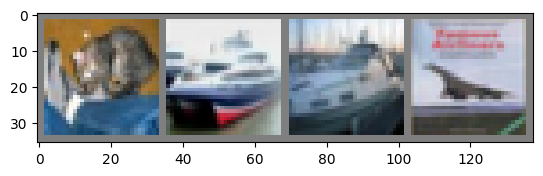

In [134]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [135]:
# complete the code here
# run inference on the four test images, show predicted class names
outputs = net(images.to(device))
max_idxs = torch.max(outputs.cpu(), dim=1).indices
print(max_idxs)
preds = [classes[i] for i in max_idxs]

print(labels, '\n', preds)

tensor([3, 8, 8, 0])
tensor([3, 8, 8, 0]) 
 ['cat', 'ship', 'ship', 'plane']


Let us look at how the network performs on the whole dataset.



In [136]:
# complete the code below to compute accuracy of the network on test images
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        matches = (preds == labels.cpu().numpy())
        correct += matches.sum()
        total += images.shape[0]

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


Let's look at the classes that performed well, and the classes that did
not perform well:



In [137]:
# complete the code below, print accuracy for each class

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        matches = (preds == labels.cpu().numpy())

        for i in range(len(classes)):  
            class_matches = matches[labels.cpu().numpy() == i]
            class_correct[i] += class_matches.sum()
            class_total[i] += (labels.cpu().numpy() == i).sum()


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 66 %
Accuracy of  bird : 34 %
Accuracy of   cat : 27 %
Accuracy of  deer : 62 %
Accuracy of   dog : 39 %
Accuracy of  frog : 44 %
Accuracy of horse : 69 %
Accuracy of  ship : 78 %
Accuracy of truck : 57 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor on to the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [138]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = inputs.to(device), labels.to(device)

You are asked to modify the code above to train on GPU instead of CPU.
Report any speedup observed. You have to request an instance of GPU runtime type for this part.

In [139]:
# complete the code below
net.train()
for epoch in range(3):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # complete the code here
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.158
[1,  4000] loss: 1.166
[1,  6000] loss: 1.160
[1,  8000] loss: 1.159
[1, 10000] loss: 1.190
[1, 12000] loss: 1.185
[2,  2000] loss: 1.085
[2,  4000] loss: 1.109
[2,  6000] loss: 1.140
[2,  8000] loss: 1.139
[2, 10000] loss: 1.144
[2, 12000] loss: 1.126
[3,  2000] loss: 1.062
[3,  4000] loss: 1.061
[3,  6000] loss: 1.074
[3,  8000] loss: 1.101
[3, 10000] loss: 1.143
[3, 12000] loss: 1.099
Finished Training
